# Load and visualize past aircraft trajectories over a given zone with OpenSky historical database 

In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import datetime
from collections import defaultdict
import paramiko
import pandas as pd
import geopandas as gpd
import contextily as ctx

#### <br> Documentation is available here: https://opensky-network.org/data/impala

#### *In order to get access to this historical database, you need an OpenSky account to fill the following fields*

In [3]:
username = "your_username"
password = "your_password"

#### Other parameters

In [4]:
# Request parameters (ex: SAMU helicopters flights over Paris during summer 2020)
callsign = "%SAMU%"
icao24 = "%"
start = datetime.datetime(2020, 6, 1, 8, 0, 0)
end = datetime.datetime(2020, 9, 15, 9, 5, 0)
lat_min, lat_max = 48.76, 48.95
lon_min, lon_max = 2.17, 2.5

# Visualization parameters
time_between_trajs = 300  # if two points have consecutive times of more than that, we consider two trajectories for the same icao24
tile_zoom = 12  # zoom of map
figsize = (15, 15)  # size of figure
markersize = 2  # size of plot for each position
cmap = "nipy_spectral"  # matplotlib colormap (colors of trajectories)
dpi = 300  # resolution of image

In [5]:
start_time = int(start.timestamp())
start_hour = start_time - (start_time % 3600)
end_time = int(end.timestamp())
end_hour = end_time - (end_time % 3600)

#### <br> Requesting data...

In [6]:
request = (
    f"-q select * from state_vectors_data4"
    f" where callsign like '{callsign}'"
    f" and icao24 like '{icao24}'"
    f" and time>={start_time} and time<={end_time}"
    f" and hour>={start_hour} and hour<={end_hour}"
    f" and lat>={lat_min} and lat<={lat_max}"
    f" and lon>={lon_min} and lon<={lon_max}"
)

In [7]:
p = paramiko.SSHClient()
p.set_missing_host_key_policy(paramiko.AutoAddPolicy())
p.connect("data.opensky-network.org", port=2230, username=username, password=password)
stdin, stdout, stderr = p.exec_command(request)
opt = stdout.readlines()

#### <br> Loading data into dataframes

In [8]:
columns = [
    "time",
    "icao24",
    "lat",
    "lon",
    "velocity",
    "heading",
    "vertrate",
    "callsign",
    "onground",
    "alert",
    "spi",
    "squawk",
    "baroaltitude",
    "geoaltitude",
    "lastposupdate",
    "lastcontact",
    "hour",
]

In [9]:
def get_line_lst(line_txt):
    lst = line_txt.split("|")
    filter_lst = [elt.strip() for elt in lst]
    while filter_lst[0] == "":
        filter_lst = filter_lst[1:]
    while filter_lst[-1] == "":
        filter_lst = filter_lst[:-1]
    return filter_lst

In [10]:
lst_of_lst = []
for i in range(3, len(opt) - 1):
    if opt[i][:2] != "+-":
        l = get_line_lst(opt[i])
        if len(l) != len(columns):
            print("Error in parsing line: ")
            print(l)
            print(opt[i])
        lst_of_lst.append(l)

In [11]:
df = pd.DataFrame(lst_of_lst, columns=columns)
df.dropna(inplace=True)
df = df[df["callsign"] != "callsign"]
df = df[df["callsign"] != ""]
df["latitude"] = df["lat"].apply(lambda x: float(x))
df["longitude"] = df["lon"].apply(lambda x: float(x))

In [12]:
l = list(df.callsign.unique())
l.sort()
print("Callsigns of flights loaded: ")
print(l)

Callsigns of flights loaded: 
['SAMU21', 'SAMU44', 'SAMU80', 'SAMU86']


In [13]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs={"init": "epsg:4326"},  # WGS84
)
gdf.head()

,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,spi,squawk,baroaltitude,geoaltitude,lastposupdate,lastcontact,hour,latitude,longitude,geometry
0,1599125964,39ac48,48.76002502441406,2.345721905048077,57.16118752539223,357.4208524997166,1.95072,SAMU21,false,false,false,7015,358.14,487.6800000000001,1599125963.138,1599125963.945,1599123600,48.760025,2.345722,POINT (2.34572 48.76003)
1,1599125965,39ac48,48.76002502441406,2.345721905048077,57.63839391884726,358.4656585002992,1.6256,SAMU21,false,false,false,7015,358.14,487.6800000000001,1599125963.138,1599125964.997,1599123600,48.760025,2.345722,POINT (2.34572 48.76003)
2,1599125966,39ac48,48.76132771120233,2.345653333162006,57.62002457923044,359.4884441334129,1.6256,SAMU21,false,false,false,7015,365.76,495.3,1599125965.692,1599125965.931,1599123600,48.761328,2.345653,POINT (2.34565 48.76133)
3,1599125967,39ac48,48.76185607910156,2.345721905048077,58.13444825631976,0.5070290609147755,2.60096,SAMU21,false,false,false,7015,365.76,487.68,1599125966.83,1599125966.953,1599123600,48.761856,2.345722,POINT (2.34572 48.76186)
4,1599125968,39ac48,48.76253806938559,2.345725611636513,58.1685814121658,2.027322700500196,2.92608,SAMU21,false,false,false,7015,365.76,502.92,1599125968,1599125968,1599123600,48.762538,2.345726,POINT (2.34573 48.76254)


#### Add column to have an unique identifier for each trajectory (same icao24 but different trajectories)

In [14]:
gdf["prev_time"] = gdf.time.shift()
map_time_traj = defaultdict(dict)

for icao, sgdf in gdf.groupby("icao24"):
    map_time_traj[icao][sgdf.iloc[0]["time"]] = icao + "_1"
    n_traj = 1
    for i in range(1, sgdf.shape[0]):
        time = sgdf.iloc[i]["time"]
        diff = int(time) - int(sgdf.iloc[i]["prev_time"])
        if diff > time_between_trajs:
            n_traj += 1
        map_time_traj[icao][time] = icao + "_" + str(int(n_traj))

gdf["icao24_traj"] = gdf.apply(lambda x: map_time_traj[x.icao24][x.time], axis=1)

#### <br> Visualize trajectories

#### Load map tiles with contextily

In [15]:
bck, ext = ctx.bounds2img(lon_min, lat_min, lon_max, lat_max, tile_zoom, ll=True)

#### Plot all trajectories on the map and save image

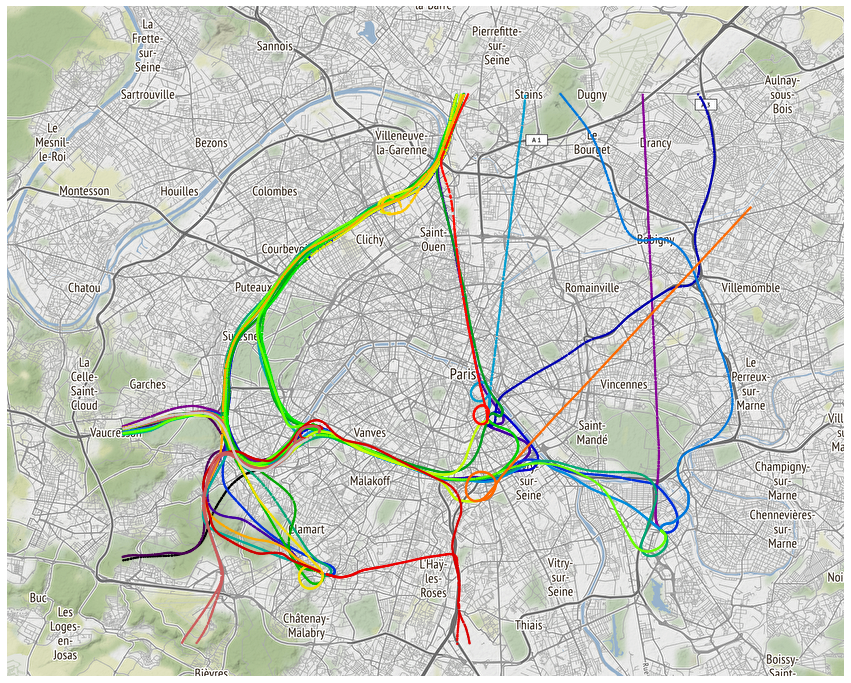

In [17]:
f, ax = plt.subplots(figsize=figsize)
ax.imshow(bck, extent=ext, interpolation="sinc", aspect="equal")
gdf = gdf.to_crs(epsg=3857)  # web mercator
trajs = gdf.dissolve(by="icao24_traj")
trajs.plot(ax=ax, alpha=1.0, cmap=cmap, markersize=markersize)
ax.set_axis_off()
plt.savefig("historical.png", dpi=dpi, bbox_inches="tight")
plt.show()